# Analysis of Caffeine Levels in Coffee Images

### Imports

In [62]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


## Analysis

#### Testing Calcuation on One image

In [63]:
# Function to Calculate Image Darkness
def calculate_image_darkness_opencv(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate the average pixel intensity
    average_intensity = np.mean(img)

    return average_intensity

def calculate_image_darkness_pil(image_path):
    # Load the image and convert to grayscale
    img = Image.open(image_path).convert('L')

    # Convert the image into np array
    img_array = np.array(img)

    # Calculate the average pixel intensity
    average_intensity = np.mean(img_array)

    return average_intensity

# Function to display image
def display_image(image_path):
    img = Image.open(image_path)
    img_gray = img.convert('L')
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.title('Grayscale Image')
    plt.imshow(img_gray, cmap='gray')
    
    plt.show()

151.20031261841606
151.20031261841606


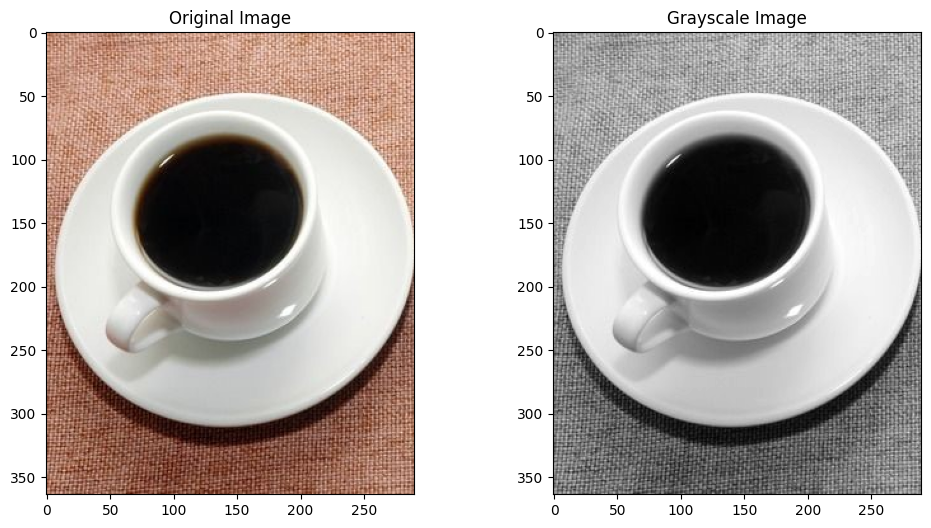

In [64]:
path = '../images/coffee1.jpg'

val1 = calculate_image_darkness_opencv(path)
print(val1)

val2 = calculate_image_darkness_pil(path)
print(val2)

display_image(path)

## Model Training

### Training Models

In [65]:
# Function to load images and calculate their intensities
def load_images_and_calculate_intensities(folder_path, img_size=(64, 64)):
    images = []
    intensities = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            image_path = os.path.join(folder_path, filename)
            
            # Load and preprocess the image
            img = load_img(image_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0  # Normalize to [0, 1]
            
            # Calculate the intensity using the function you made
            intensity = calculate_image_darkness_pil(image_path)
            
            images.append(img_array)
            intensities.append(intensity)
    
    return np.array(images), np.array(intensities)

In [66]:
folder_path = '../data/Cafelitos.v1i.tensorflow/valid copy'
img_size = (64, 64)

X, y = load_images_and_calculate_intensities(folder_path, img_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Build and Train CNN

In [67]:
def create_model(input_shape):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)  # Single output for intensity
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

input_shape = (img_size[0], img_size[1], 3)
model = create_model(input_shape)
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test set: {mae}')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,793 (1.61 MB)

 Trainable params: 421,793 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 12095.3262 - mae: 101.6871 - val_loss: 3363.7581 - val_mae: 56.4909
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2265.2244 - mae: 42.1597 - val_loss: 931.9412 - val_mae: 25.1200
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 569.7874 - mae: 18.3149 - val_loss: 172.7107 - val_mae: 10.3678
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 223.9286 - mae: 11.9490 - val_loss: 178.0724 - val_mae: 10.8360
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 177.4402 - mae: 11.0048 - val_loss: 154.0678 - val_mae: 9.7914
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 137.9920 - mae: 8.9730 - val_loss: 122.0887 - val_mae: 8.6479
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 114.1984 - mae: 8.6141 - val_loss: 125.4187 - val_mae: 9.0902
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 109.8625 - mae: 8.2203 - val_loss: 117.8173 - val_mae: 9.0088
Epoc

KeyboardInterrupt: 

#### Making a Prediction

In [ ]:
# Predict the intensity of a new image
def predict_intensity(image_path, model, img_size=(64, 64)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    prediction = model.predict(img_array)
    return prediction[0][0]

# Example prediction
new_image_path = '../images/coffee1.jpg'
predicted_intensity = predict_intensity(new_image_path, model)
print(f"Predicted Intensity: {predicted_intensity}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted Intensity: 149.01412963867188


## Metrics

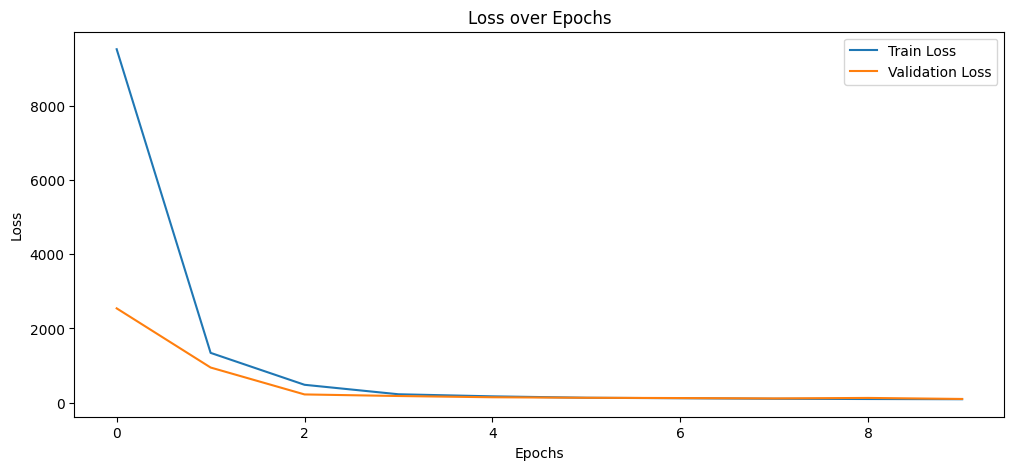

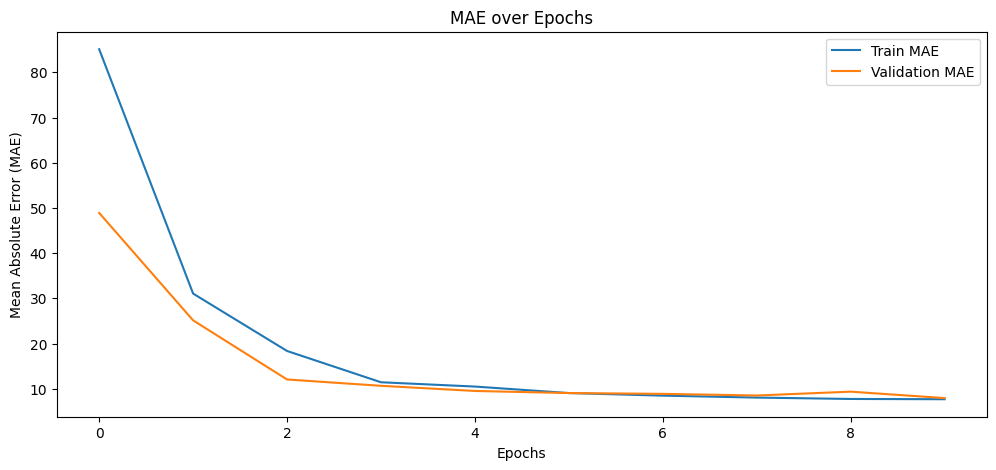

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plotting the training and validation Mean Absolute Error (MAE)
plt.figure(figsize=(12, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE over Epochs')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


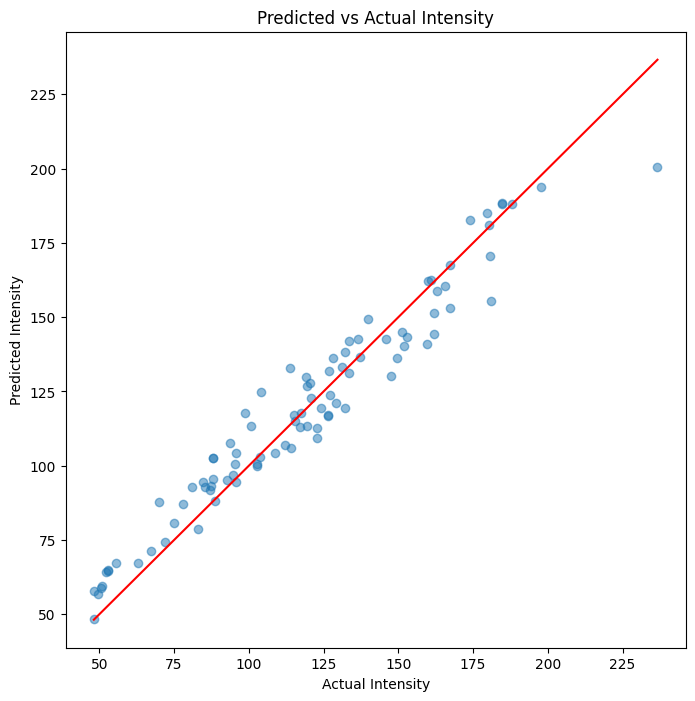

In [ ]:
# visualize how well the predicted values align with the actual values
y_pred = model.predict(X_test).flatten()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.xlabel('Actual Intensity')
plt.ylabel('Predicted Intensity')
plt.title('Predicted vs Actual Intensity')
plt.show()


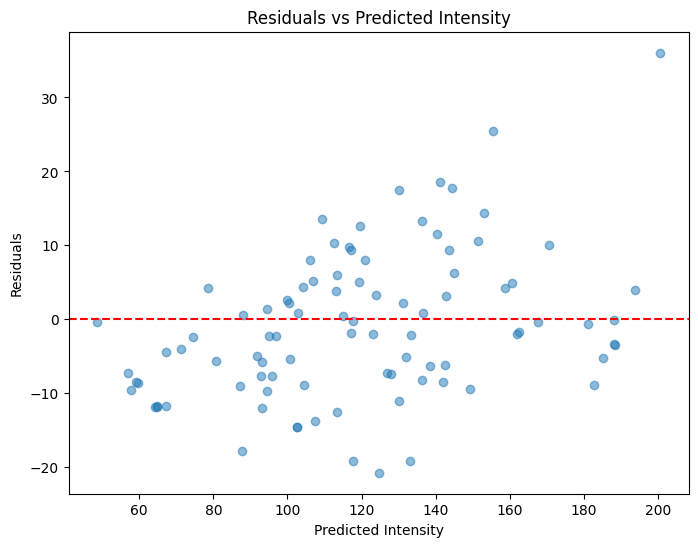

In [ ]:
# identify patterns in the prediction errors
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Intensity')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Intensity')
plt.show()
